# QAOA

This notebook demonstrates the Classiq performance re. the Quantum Approximate Optimization Algorithm (QAOA), focusing on the Max Clique problem.

## 1. Calling the Built-in QAOA

This section calls the built-in QAOA of Classiq, constructing the corresponding quantum model from a combinatorial optimization Pyomo model.

### 1.1. Generating a Pyomo Model

In [2]:
import time

import networkx as nx
import numpy as np
import pyomo.environ as pyo

np.random.seed(2)


def define_max_clique_model(graph):
    model = pyo.ConcreteModel()

    # each x_i states if node i belongs to the cliques
    model.x = pyo.Var(graph.nodes, domain=pyo.Binary)
    x_variables = np.array(list(model.x.values()))

    # define the complement adjacency matrix as the matrix where 1 exists for each non-existing edge
    adjacency_matrix = nx.convert_matrix.to_numpy_array(graph, nonedge=0)
    complement_adjacency_matrix = (
        1
        - nx.convert_matrix.to_numpy_array(graph, nonedge=0)
        - np.identity(len(model.x))
    )

    # constraint that 2 nodes without an edge in the graph cannot be chosen together
    model.clique_constraint = pyo.Constraint(
        expr=x_variables @ complement_adjacency_matrix @ x_variables == 0
    )

    # maximize the number of nodes in the chosen clique
    model.value = pyo.Objective(expr=sum(x_variables), sense=pyo.maximize)

    return model

Setting a specific problem and some hyperparameters.

In [3]:
QAOA_NUM_LAYERS = 10
NUM_SHOTS = 1e4
NUM_QUBITS = 7
graph = nx.erdos_renyi_graph(NUM_QUBITS, 0.6, seed=79)
max_clique_model = define_max_clique_model(graph)

In [4]:
# transpilation_options = {"classiq": "custom", "qiskit": 3}
transpilation_options = {"classiq": "auto optimize", "qiskit": 1}

### 1.2 Constructing, Synthesizing, and Running a QAOA Model


In [5]:
from classiq import (
    CustomHardwareSettings,
    Preferences,
    QuantumProgram,
    construct_combinatorial_optimization_model,
    execute,
    set_execution_preferences,
    set_preferences,
    show,
    synthesize,
)
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig
from classiq.execution import ExecutionPreferences

qaoa_config = QAOAConfig(num_layers=QAOA_NUM_LAYERS)
optimizer_config = OptimizerConfig(max_iteration=400, alpha_cvar=1)

qmod = construct_combinatorial_optimization_model(
    pyo_model=max_clique_model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)


execution_preferences = ExecutionPreferences(num_shots=NUM_SHOTS)
preferences = Preferences(
    custom_hardware_settings=CustomHardwareSettings(basis_gates=["cx", "u"]),
    transpilation_option=transpilation_options["classiq"],
)

qmod = set_execution_preferences(qmod, execution_preferences)
qmod = set_preferences(qmod, preferences=preferences)

qprog = synthesize(qmod)
res = execute(qprog).result()
depth_classiq = qprog.transpiled_circuit.depth
cx_counts_classiq = qprog.transpiled_circuit.count_ops["cx"]
classiq_solving_time = res[0].value.time

interations_classiq = [
    intermediate_result.iteration_number
    for intermediate_result in res[0].value.intermediate_results
]
results_classiq = [
    -intermediate_result.mean_all_solutions
    for intermediate_result in res[0].value.intermediate_results
]

## 2. Comparing to Qiskit

We use qiskit version 1.0. 

Qiskit has no module in which to specify a generic optimization problem; therefore, you have to do the preprocessing and post-processing yourself.
Retrieve the Hamiltonian that enters into the VQE.

In [6]:
from typing import List

from classiq import Pauli as ClassiqPauli


def get_classiq_hamiltonian(execution_result) -> List[List[str]]:
    hamiltonian_result = execution_result[1].value
    parsed_pauli_list = list()
    for pauli_term in hamiltonian_result:
        pauli_str = "".join(ClassiqPauli(pauli).name for pauli in pauli_term["pauli"])
        coefficient = pauli_term["coefficient"]
        parsed_pauli_list.append([pauli_str, coefficient])

    return parsed_pauli_list

Define a function for running QAOA on Qiskit and returning the results.

**Due to long runtime the code for generating the qiskit data is commented out and the results are hard-coded  in the notebook. For running the full code please uncomment the code three cells below.**

In [7]:
qiskit_result = np.load("qiskit_res.npy")

In [8]:
max_classiq_iter = len(interations_classiq)

In [9]:
depth_qiskit = 1646
cx_counts_qiskit = 1660
iterations_qiskit = np.linspace(1, len(qiskit_result), len(qiskit_result))

In [10]:
# from importlib.metadata import version
# try:
#     import qiskit
#     if version('qiskit') != "1.0.0":
#       !pip uninstall qiskit -y
#       !pip install qiskit==1.0.0
# except ImportError:
#     !pip install qiskit==1.0.0

In [11]:
# from qiskit import QuantumCircuit, transpile
# from qiskit.primitives import Estimator, Sampler
# from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector
# from qiskit.result import QuasiDistribution
# from qiskit_algorithms.minimum_eigensolvers import QAOA
# from qiskit_algorithms.optimizers import COBYLA


# def qiskit_qaoa(hamiltonian, qaoa_num_layers, num_qubits):
#     """
#     Gets a Hamiltonian for QAOA and num of quantum layers, returning the most probable solution and its corresponding cost
#     as well as intermediate results
#     """
#     counts = []
#     values = []

#     def store_intermediate_result(eval_count, parameters, mean, std):
#         # callable to store results
#         counts.append(eval_count)
#         values.append(mean)

#     def objective_value(x, hamiltonian):
#         # get objective value for a given computational basis state

#         qc = QuantumCircuit(num_qubits)
#         for k in range(num_qubits):
#             if x[k] == 1:
#                 qc.x(k)

#         estimated_cost = estimator.run(qc, hamiltonian).result().values[0]

#         return -estimated_cost

#     def bitfield(n: int, L: int) -> list[int]:
#         # binary representation as list
#         result = np.binary_repr(n, L)
#         return [int(digit) for digit in result]  # [2:] to chop off the "0b" part

#     def sample_most_likely(state_vector: QuasiDistribution | Statevector) -> np.ndarray:
#         """Compute the most likely binary string from the state vector.
#         Args:
#             state_vector: State vector or quasi-distribution.

#         Returns:
#             Binary string as an array of ints.
#         """
#         if isinstance(state_vector, QuasiDistribution):
#             values = list(state_vector.values())
#         else:
#             values = state_vector
#         n = int(np.log2(len(values)))
#         k = np.argmax(np.abs(values))
#         x = bitfield(k, n)
#         x.reverse()
#         return np.asarray(x)

#     estimator = Estimator(options={"shots": int(NUM_SHOTS)})
#     sampler = Sampler()
#     optimizer = COBYLA()
#     qaoa = QAOA(
#         sampler, optimizer, reps=qaoa_num_layers, callback=store_intermediate_result
#     )
#     start = time.time()
#     result = qaoa.compute_minimum_eigenvalue(hamiltonian)
#     solving_time = time.time() - start
#     x = sample_most_likely(result.eigenstate)

#     transpiled_circuit = transpile(
#         result.optimal_circuit,
#         basis_gates=["u", "cx"],
#         optimization_level=transpilation_options["qiskit"],
#     )

#     return (
#         transpiled_circuit.depth(),
#         transpiled_circuit.count_ops()["cx"],
#         solving_time,
#         x,
#         objective_value(x, hamiltonian),
#         counts,
#         values,
#     )

The same QAOA with Qiskit

In [12]:
# pauli_list = get_classiq_hamiltonian(res)
# hamiltonian = SparsePauliOp.from_list(pauli_list)

# (
#     depth_qiskit,
#     cx_counts_qiskit,
#     time_qiskit,
#     most_probable_state,
#     cost,
#     iterations_qiskit,
#     results_qiskit,
# ) = qiskit_qaoa(hamiltonian, QAOA_NUM_LAYERS, NUM_QUBITS)

# qiskit_result = np.real(results_qiskit[0:max_classiq_iter])
# iterations_qiskit = iterations_qiskit[0:max_classiq_iter]

## 3. Plotting the Data

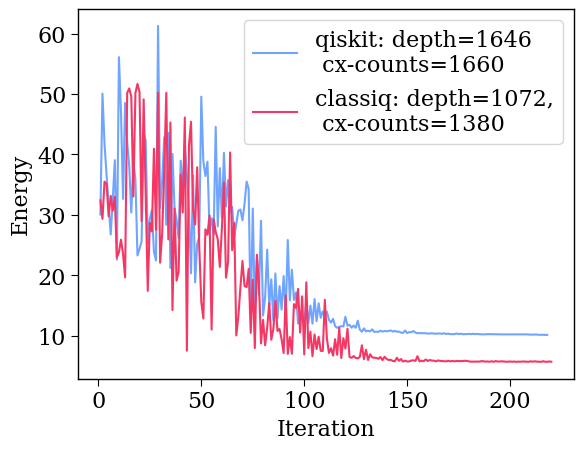

In [13]:
import matplotlib.pyplot as plt

classiq_color = "#F43764"
qiskit_color = "#6FA4FF"
plt.rcParams["font.family"] = "serif"
plt.rc("savefig", dpi=300)

plt.rcParams["axes.linewidth"] = 1
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.minor.size"] = 5
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.minor.size"] = 5

qiskit_label = f"qiskit: depth={depth_qiskit} \n cx-counts={cx_counts_qiskit}"
classiq_label = f"classiq: depth={depth_classiq},\n cx-counts={cx_counts_classiq}"
plt.plot(
    iterations_qiskit,
    qiskit_result,
    "-",
    label=qiskit_label,
    linewidth=1.5,
    color=qiskit_color,
)
plt.plot(
    interations_classiq[0:max_classiq_iter],
    results_classiq[0:max_classiq_iter],
    "-",
    label=classiq_label,
    linewidth=1.5,
    color=classiq_color,
)

# plt.ylim(0,90)
plt.ylabel("Energy", fontsize=16)
plt.xlabel("Iteration", fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(loc="upper right", fontsize=16)